In [1]:
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import pickle
from torchmetrics import StructuralSimilarityIndexMeasure
from statistics import median, mean
from matplotlib import pyplot as plt
import numpy as np
from pytorch_msssim import ssim, ms_ssim, SSIM, MS_SSIM
from torchsummary import summary
import json
from tqdm import tqdm
from glob import glob
import sys
path = "/study/mrphys/skunkworks/kk/mriUnet"
sys.path.insert(0,path)
import unet
from torchvision import transforms
from torch.utils.data import Dataset
import h5py
from sklearn.model_selection import KFold as kf
import os
import nibabel as nib

xPath = sorted(glob('/scratch/mrphys/denoised/denoised_*.h5'))
samples = [p.split('/')[-1].split('_')[1].split('.')[0] for p in xPath]
T1path = [f'/study/mrphys/skunkworks/training_data/mover01/{p}/processed_data/T1_3_tv.nii' for p in samples]
gtPath = [f'/study/mrphys/skunkworks/training_data/mover01/{p}/processed_data/C.h5' for p in samples]

masks = [f'/scratch/mrphys/for_kk/{p}/processed_data/mpnrage_composite_bfc_tv.anat/FAST_OUTPUT/T1_fast_seg_resliced.nii.gz' for p in samples]

def getComplexSlices(path, return_scale=False):

    with h5py.File(path,'r') as hf:
        prefix = 'C_000_0'
        imagestackReal = []
        imagestackImag = []
        for i in range(10):
            n = prefix + str(i).zfill(2)
            image = hf['Images'][n]
            imagestackReal.append(np.array(image['real']))
            imagestackImag.append(np.array(image['imag']))
            if i==0:
                normScale = np.max(np.abs(np.array(image['real'])+np.array(image['imag'])*1J))
        imagestackReal = np.array(imagestackReal)/normScale
        imagestackImag = np.array(imagestackImag)/normScale
        
    if return_scale:
        return imagestackReal+imagestackImag*1j, normScale
    else:
        return imagestackReal+imagestackImag*1j
    
class T1Dataset(Dataset):
    
    def __init__(self, index, gt=False, norm_factor=1000):
    
        if gt:
            self.x_path = gtPath[index]
        else:
            self.x_path = xPath[index]  
        self.y_path = T1path[index]
        self.mask_path = masks[index]
        
        self.x = getComplexSlices(self.x_path)
        self.y = np.transpose(nib.load(self.y_path).get_fdata()).reshape(1,256,256,256)/norm_factor
        self.mask = nib.load(self.mask_path).get_fdata().transpose(2,1,0).reshape(1,256,256,256)
        self.y = np.concatenate([self.y,self.mask],axis=0)

    def __getitem__(self, index):
        if index<256:
            return self.x[:,index,:,:], self.y[:,index,:,:]
        elif index<512:
            index = index-256
            return self.x[:,:,index,:], self.y[:,:,index,:]
        else:
            index = index-512
            return self.x[:,:,:,index], self.y[:,:,:,index]

    def __len__(self):
        return 768

In [2]:
len(samples)

56

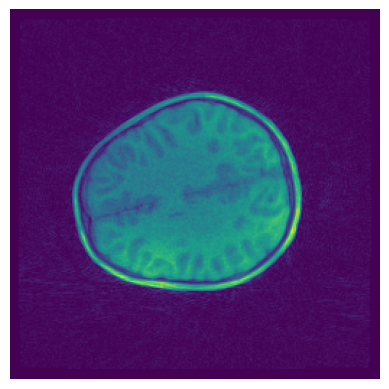

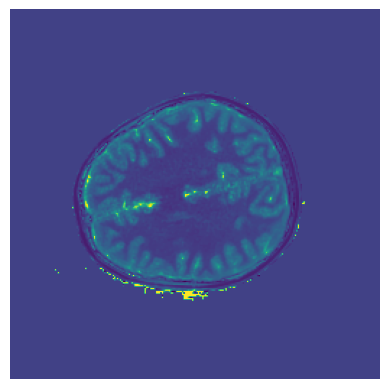

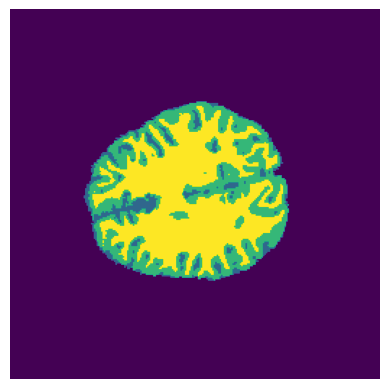

In [3]:
dataset = T1Dataset(10, gt=False)
x,y = dataset[150]
plt.axis('off')
plt.imshow(np.abs(x[0]))
plt.show()
plt.axis('off')
plt.imshow(np.abs(y[0]))
plt.show()
plt.axis('off')
plt.imshow(np.abs(y[1]))
plt.show()

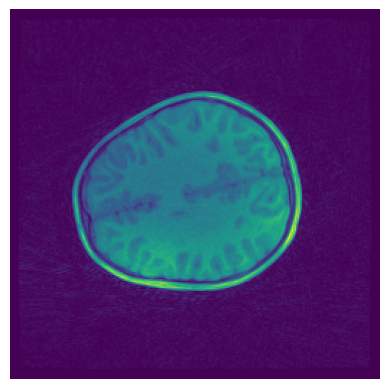

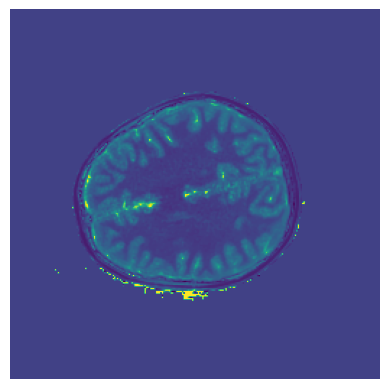

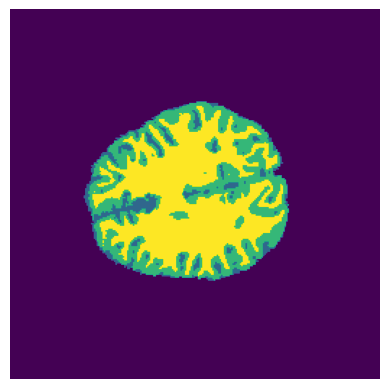

In [4]:
dataset = T1Dataset(10, gt=True)
x,y = dataset[150]
plt.axis('off')
plt.imshow(np.abs(x[0]))
plt.show()
plt.axis('off')
plt.imshow(np.abs(y[0]))
plt.show()
plt.axis('off')
plt.imshow(np.abs(y[1]))
plt.show()

In [5]:
try:
    os.mkdir('/scratch/mrphys/T1pickled')
except:
    pass
        
for i in tqdm(range(len(T1path))):
    dataset = T1Dataset(i, gt=False)
    with open(f'/scratch/mrphys/T1pickled/Denoise_T1dataset_{i}.pickle', 'wb') as f:
        pickle.dump(dataset, f)

100%|███████████████████████████████████████████████████████████████████████████████████| 56/56 [10:15<00:00, 10.99s/it]


In [6]:
for i in tqdm(range(len(T1path))):
    dataset = T1Dataset(i, gt=True)
    with open(f'/scratch/mrphys/T1pickled/GT_T1dataset_{i}.pickle', 'wb') as f:
        pickle.dump(dataset, f)

100%|███████████████████████████████████████████████████████████████████████████████████| 56/56 [08:25<00:00,  9.03s/it]


In [1]:
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import pickle
from torchmetrics import StructuralSimilarityIndexMeasure
from statistics import median, mean
from matplotlib import pyplot as plt
import numpy as np
from pytorch_msssim import ssim, ms_ssim, SSIM, MS_SSIM
from torchsummary import summary
import json
from tqdm import tqdm
from glob import glob
import sys
path = "/study/mrphys/skunkworks/kk/mriUnet"
sys.path.insert(0,path)
import unet
from torchvision import transforms
from torch.utils.data import Dataset
import h5py
from sklearn.model_selection import KFold as kf
import os
import nibabel as nib

class T1Dataset(Dataset):
    
    def __init__(self, indices):
        self.denoised_path = sorted(glob("/study/mrphys/skunkworks/training_data/mover01/*/processed_data/acc_2min/T1_3_tv.nii"))
        self.groundtruth_path = sorted(glob("/study/mrphys/skunkworks/training_data/mover01/*/processed_data/T1_3_tv.nii"))
        self.mask_path = sorted(glob('/scratch/mrphys/masks/*'))
        self.indices = indices

    def __getitem__(self, index):
        index = self.indices[index]
        X = (np.transpose(nib.load(self.denoised_path[index]).get_fdata())/1000).reshape(1,256,256,256)
        Y = (np.transpose(nib.load(self.groundtruth_path[index]).get_fdata())/1000).reshape(1,256,256,256)
        mask = np.load(self.mask_path[index])
        return X, Y, mask

    def __len__(self):
        return len(self.ndices)

In [3]:
dataset = T1Dataset()

In [4]:
X, Y, mask = dataset[0]

In [5]:
X.shape

(1, 256, 256, 256)